In [13]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

batch_size = 4
network_width = 32
epochs = 10

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [15]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,  batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [16]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


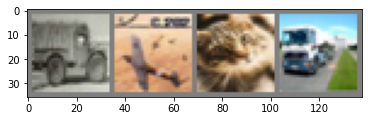

truck plane   cat truck


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=network_width,kernel_size=3) # 3 input channels for colour image, 10 filters and a kernel size of 3 to avoid overfitting
        self.pool = nn.MaxPool2d(2) # Window of size 2 (where it takes the max from)
        self.conv2 = nn.Conv2d(in_channels=network_width,out_channels=network_width*2,kernel_size=3) # The input channels are now the output channels of the previous convolution, it's generally good practice to double the number of feature maps for every convolution layer.
        self.fc1 = nn.Linear(network_width * 2 * 6 * 6, 120)

        self.dropout1 = nn.Dropout(0.5) # Randomly zero some elements to prevent co-adaptaption of neurons (work independently)

        self.fc2 = nn.Linear(120, 10) # Reduce to 10 output nodes because there is 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
        x = self.fc2(x)
        return x

model = Model()
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

dataiter = iter(trainloader)
images, labels = dataiter.next()

logps = model(images)
loss = criterion(logps, labels)

In [20]:
time0 = time()
for e in range(epochs):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f"[{e + 1}, {i + 1}] loss: {running_loss / 2000}")
            running_loss = 0.0
print("\nTraining Time (in minutes) =",(time()-time0)/60)

[1, 2000] loss: 1.9549497325122356
[1, 4000] loss: 1.6362871895879507
[1, 6000] loss: 1.5586880644112826
[1, 8000] loss: 1.4923706110715866
[1, 10000] loss: 1.431638807941228
[1, 12000] loss: 1.393928697131574
[2, 2000] loss: 1.3095651779957116
[2, 4000] loss: 1.355861171875149
[2, 6000] loss: 1.2976206425465644
[2, 8000] loss: 1.291976915298961
[2, 10000] loss: 1.2864746046699584
[2, 12000] loss: 1.2671056086570025
[3, 2000] loss: 1.1920385183123872
[3, 4000] loss: 1.2055407782848924
[3, 6000] loss: 1.2142591154119
[3, 8000] loss: 1.2084515190422536
[3, 10000] loss: 1.1814399989536033
[3, 12000] loss: 1.2162958000078796
[4, 2000] loss: 1.1186195769947953
[4, 4000] loss: 1.1560234052524903
[4, 6000] loss: 1.1486854043405765
[4, 8000] loss: 1.172673456878867
[4, 10000] loss: 1.1715399456279119
[4, 12000] loss: 1.1774995206622407
[5, 2000] loss: 1.0780773179873357
[5, 4000] loss: 1.0850138439964503
[5, 6000] loss: 1.1132612524867291
[5, 8000] loss: 1.1323651535818353
[5, 10000] loss: 1.1

In [21]:
torch.save(model, './my_cifar_model.pt')

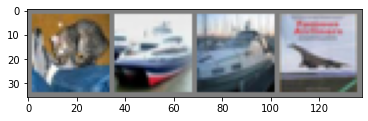

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  bird


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 64 %
Accuracy of  bird : 52 %
Accuracy of   cat : 38 %
Accuracy of  deer : 40 %
Accuracy of   dog : 52 %
Accuracy of  frog : 71 %
Accuracy of horse : 64 %
Accuracy of  ship : 73 %
Accuracy of truck : 63 %


In [64]:
from PIL import Image


def image_loader(path_to_image):
    image = Image.open(path_to_image)
    resized = image.resize((32,32), Image.ANTIALIAS)
    resized.save(path_to_image.split('.')[0] + '-32x32.jpg')
    return transform(resized).unsqueeze(0)

my_dog_image = image_loader('my-dog.jpg')

output = model(my_dog_image)
prediction = int(torch.max(output.data, 1)[1].numpy())
print(classes[prediction])

dog
